In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import h5py
import numpy as np

from vit_pytorch import ViT

sys.path.append("/home/lord225/pyrepos/explain-rl")

from ppo import PPO
import procgenwrapper

MODEL_PATH = "/home/lord225/pyrepos/explain-rl/preserve"
DATA_PATH = "/home/lord225/pyrepos/explain-rl/explain/records"

MODEL_NAME = "20250402-092247-StopOpenEarly_6_v3.1"

MODEL_PATH = os.path.join(MODEL_PATH, MODEL_NAME)
DATA_PATH = os.path.join(DATA_PATH, MODEL_NAME+"_replay.h5")

venv = procgenwrapper.ProcGenWrapper("starpilot", human=False, collect_seg=True)

model = PPO.load(MODEL_PATH,
                    env=venv, 
                    print_system_info=True,
                    custom_objects={
                        "ViT":ViT,
                    })

dataset = h5py.File(DATA_PATH, "r")

observations = np.array(dataset["observations"])
actions = np.array(dataset["actions"])
rewards = np.array(dataset["rewards"])
dones = np.array(dataset["dones"])
seg_observations = np.array(dataset["seg_observations"])
next_observations = np.array(dataset["next_observations"])

dataset.close() 

print(observations.shape)

net = model.policy
vit = net.mlp_extractor.policy_net[1]
vit


2025-04-09 12:21:59.367503: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 12:21:59.465045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-09 12:21:59.465096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-09 12:21:59.477822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-09 12:21:59.516727: I tensorflow/core/platform/cpu_feature_guar

building procgen...done
== CURRENT SYSTEM INFO ==
- OS: Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.35 # 1 SMP Fri Mar 29 23:14:13 UTC 2024
- Python: 3.9.21
- Stable-Baselines3: 2.5.0
- PyTorch: 2.6.0+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 3.1.1
- Gymnasium: 1.0.0
- OpenAI Gym: 0.26.2

== SAVED MODEL SYSTEM INFO ==
- OS: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39 # 1 SMP Tue Nov 5 00:21:55 UTC 2024
- Python: 3.9.21
- Stable-Baselines3: 2.5.0
- PyTorch: 2.6.0+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 1.2.2
- Gymnasium: 1.0.0
- OpenAI Gym: 0.15.7

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
(10000, 64, 64, 9)


ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=144, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-3): 4 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.0, inplace=False)
          (to_qkv): Linear(in_features=64, out_features=1152, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=384, out_features=64, bias=True)
            (1): Dropout(p=0.0, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): Layer

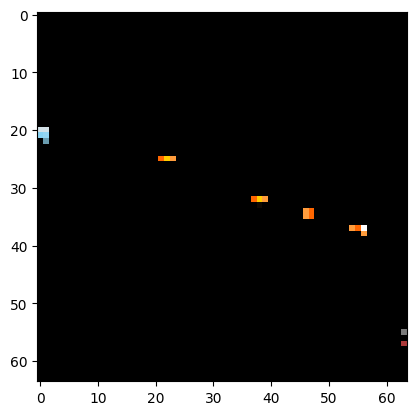

In [2]:
import matplotlib.pyplot as plt

INDEX = 110

plt.imshow(observations[INDEX][:,:,6:])

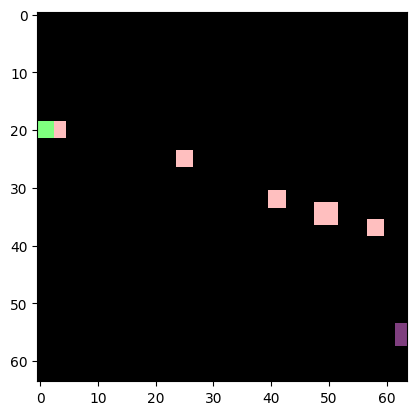

In [3]:
plt.imshow(seg_observations[INDEX][:,:,:])

In [4]:
seg_observations.shape

(10000, 64, 64, 3)

In [13]:
seg_observations.reshape(-1, seg_observations.shape[3]).shape

(40960000, 3)

In [ ]:
# # (10000, 64, 64, 3)
# unique_colors = np.unique(seg_observations.reshape(-1, seg_observations.shape[3]), axis=0)
# unique_colors, unique_colors.shape

(array([[  0,   0,   0],
        [127,  63, 127],
        [127,  63, 191],
        [127, 127, 255],
        [127, 191,  63],
        [127, 255, 127],
        [191, 255, 255],
        [255, 127, 127],
        [255, 191, 191],
        [255, 191, 255]], dtype=uint8),
 (10, 3))

In [26]:
UNIQUE_COLORS = np.array([[  0,   0,   0],
        [127,  63, 127],
        [127,  63, 191],
        [127, 127, 255],
        [127, 191,  63],
        [127, 255, 127],
        [191, 255, 255],
        [255, 127, 127],
        [255, 191, 191],
        [255, 191, 255]], dtype=np.uint8)[np.newaxis]
UNIQUE_COLORS = np.squeeze(UNIQUE_COLORS, axis=0)
UNIQUE_COLORS.shape

(10, 3)

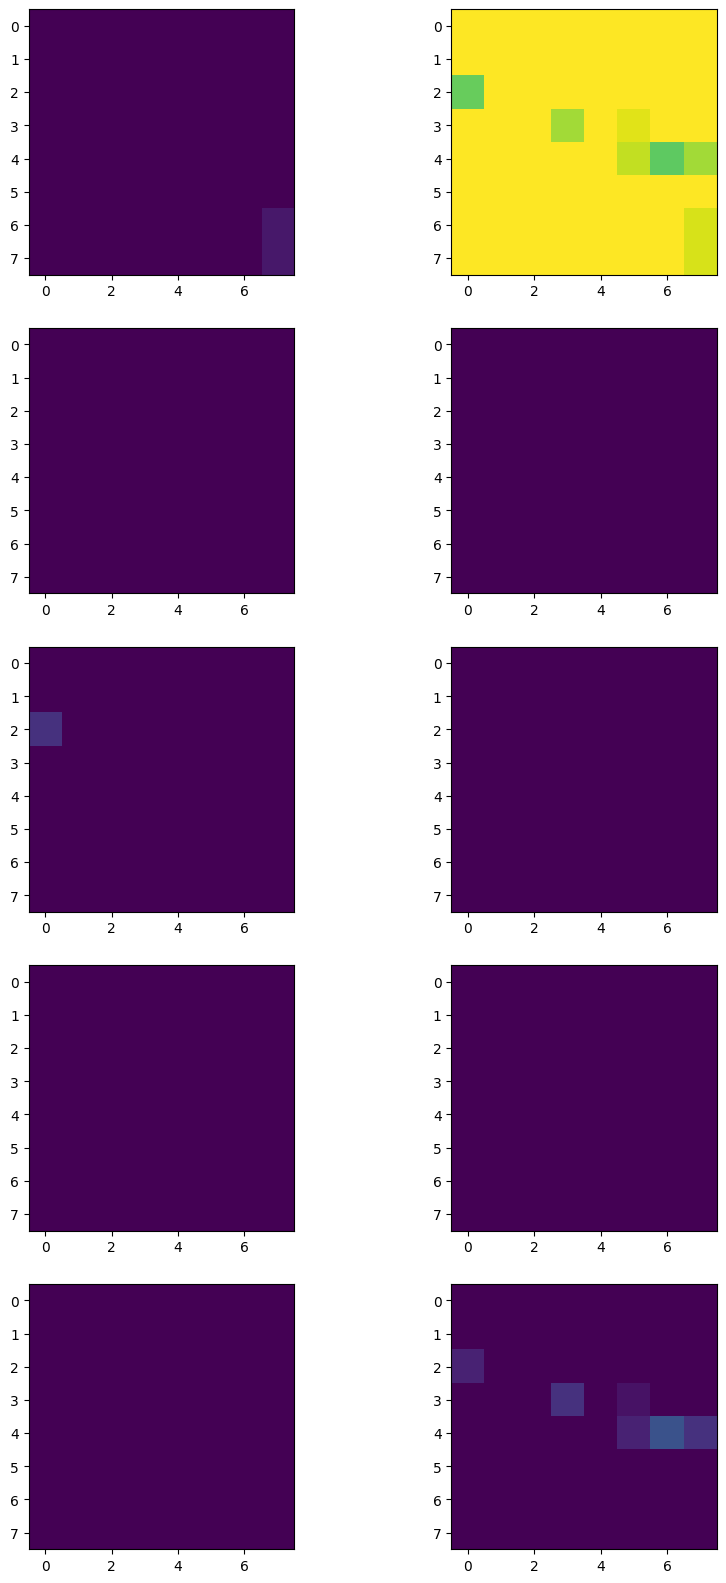

In [103]:
POOLER = nn.AvgPool2d(kernel_size=8, stride=8)

def segments_to_map(segment):
    encoded_segments = np.zeros((64, 64, len(UNIQUE_COLORS)), dtype=np.float32)

    for i in range(len(UNIQUE_COLORS)):
        mono = np.all(segment == UNIQUE_COLORS[i, :], axis=2)
        mono = mono.astype(np.float32)
        encoded_segments[:, :, i] = mono
    # resize to 16x16
    channels = POOLER(th.tensor(encoded_segments).permute(2, 0, 1)).permute(1, 2, 0).numpy()
    return channels


segmented = [
    segments_to_map(seg_observations[INDEX])
]

segmented = np.array(segmented)
segmented.shape

# subplots 7x2
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    axs[i, 1].imshow(segmented[0][:,:,2*i], vmin=0, vmax=1)
    axs[i, 0].imshow(segmented[0][:,:,2*i+1], vmin=0, vmax=1)

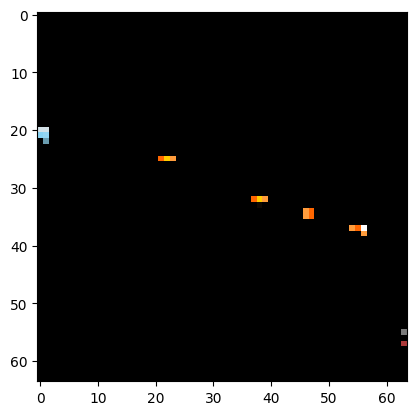

In [104]:
plt.imshow(observations[INDEX][:,:,6:])

In [105]:
segmented.shape

(1, 8, 8, 10)

In [106]:
segmented[0]

array([[[1.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      ],
        [1.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      ],
        [1.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      ],
        [1.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      ],
        [1.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      ],
        [1.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      ],
        [1.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      ],
        [1.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      ]],

       [[1.      , 0.      , 0.      , 0.     

# Figure out what each class means

In [107]:
segmented[0].shape

(8, 8, 10)

In [108]:
import tqdm

segmented = []
for i in tqdm.tqdm(range(len(seg_observations))):
    segmented.append(segments_to_map(seg_observations[i]))
segmented = np.array(segmented)
segmented.shape

100%|██████████| 10000/10000 [00:10<00:00, 921.71it/s]


(10000, 8, 8, 10)

In [47]:
# find for each segment class an example of observation, and segment (2x14) plots

# find one sample in segmented dataset where the given segment class is present
def find_segment_class_in_dataset(seg_class):
    if np.sum(segmented[INDEX][:,:,seg_class]) > 0:
        return INDEX
    for i in range(segmented.shape[0]):
        if np.sum(segmented[i][:,:,seg_class]) > 0:
            return i
    return -1

examples = []

for i in range(10):
    index = find_segment_class_in_dataset(i)
    if index != -1:
        examples.append(index)
    else:
        examples.append(-1)

print(examples)

[110, 110, 55, 60, 53, 110, 56, 54, 110, 52]


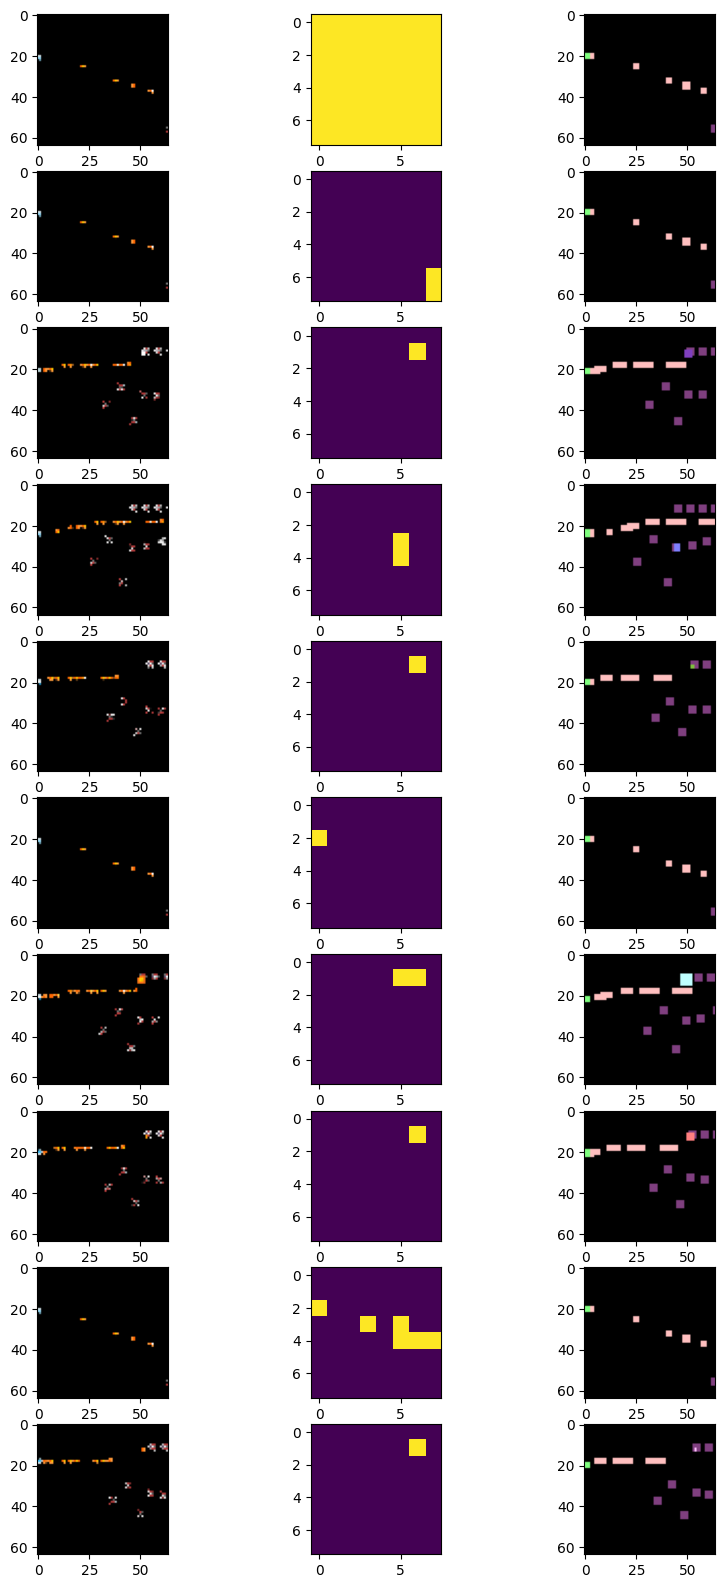

In [48]:
# show examples
fig, axs = plt.subplots(10, 3, figsize=(10, 20))

for i in range(10):
    if examples[i] != -1:
        axs[i, 0].imshow(observations[examples[i]][:,:,6:])
        axs[i, 1].imshow(segmented[examples[i]][:,:,i], vmin=0, vmax=1)
        axs[i, 2].imshow(seg_observations[examples[i]][:,:,:])
    else:
        axs[i, 0].imshow(np.zeros((64, 64, 3), dtype=np.uint8))
        axs[i, 1].imshow(np.zeros((64, 64, 3), dtype=np.uint8))
        axs[i, 2].imshow(np.zeros((64, 64, 3), dtype=np.uint8))

In [87]:
features_names = [
    "bg",
    "enemy",
    "enemy_bullet",
    "enemy2",
    "enemy_fire",
    "player",
    "explosion",
    "enemy_fire",
    "player_bullet",
    "enemy_bullet",
]

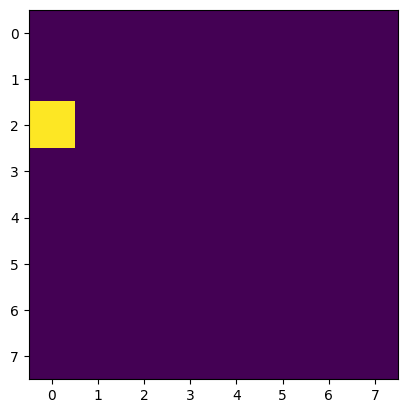

In [50]:
#plt.imshow(segmented[INDEX][:,:,0])
plt.imshow(segmented[INDEX][:,:,5])

In [51]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

In [52]:
actions[0]

12

Wyjaśniać:
Spróbować na subset akcji (na przykład same kierunki)
Albo czy fire
zmneijszyć rozdzielczość po ludzku
Dodać customowe cechy


In [53]:
model = tree.DecisionTreeClassifier(max_leaf_nodes=50, max_depth=5)


X = segmented.reshape(-1, segmented.shape[1]*segmented.shape[2]*segmented.shape[3])
y = actions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print("Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))
print("Report Train")
print(classification_report(y_train, y_pred_train))


Accuracy: 0.1755
              precision    recall  f1-score   support

           0       0.27      0.21      0.23       252
           1       0.00      0.00      0.00        33
           2       0.17      0.89      0.29       256
           3       0.17      0.01      0.01       137
           4       0.00      0.00      0.00        19
           5       0.00      0.00      0.00        58
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00        18
           9       0.15      0.11      0.12       276
          10       0.00      0.00      0.00        13
          11       0.14      0.13      0.14       253
          12       0.18      0.03      0.05       269
          13       0.00      0.00      0.00       142
          14       0.00      0.00      0.00       246

    accuracy                           0.18      2000
   macro avg       0.07      0.09      0.06      2000
weighted 

/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [54]:
# check leaf nodes vs test-f1 score
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import tqdm
from joblib import Parallel, delayed

def train_model(model, X_train, y_train, X_test, y_test):
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    return f1_score(y_test, y_pred, average='macro'), f1_score(y_train, y_pred_train, average='macro')

leaf_nodes = tqdm.trange(10, 1000, 1)

from joblib import parallel_backend

with parallel_backend('loky'): 
    f1_scores = list(tqdm.tqdm(
        Parallel(n_jobs=-1)(
            delayed(train_model)(tree.DecisionTreeClassifier(max_leaf_nodes=i), X_train, y_train, X_test, y_test)
            for i in leaf_nodes
        ),
        total=len(leaf_nodes)
    ))

100%|██████████| 990/990 [00:00<00:00, 4639509.45it/s]


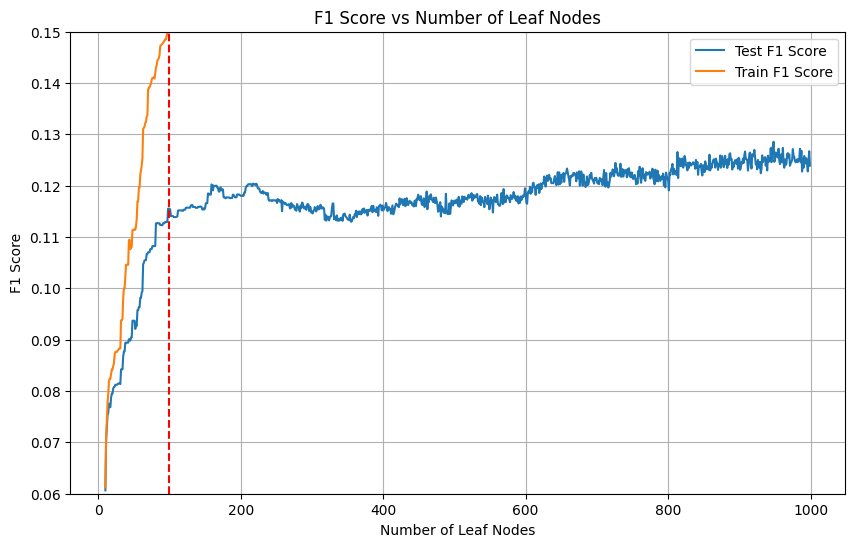

In [55]:
# Extract F1 scores for test and train
f1_scores_test = [score[0] for score in f1_scores]
f1_scores_train = [score[1] for score in f1_scores]

# Plot the F1 scores
plt.figure(figsize=(10, 6))
plt.plot(range(10, 1000, 1), f1_scores_test, label='Test F1 Score')
plt.plot(range(10, 1000, 1), f1_scores_train, label='Train F1 Score')

# Add labels, title, and legend
plt.xlabel('Number of Leaf Nodes')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Leaf Nodes')
plt.legend()
plt.ylim(0.06, 0.15)
plt.axvline(x=100, color='r', linestyle='--')
plt.grid()
plt.show()

In [56]:
x = GridSearchCV(
    estimator=model,
    param_grid={
        "max_leaf_nodes": [10, 20, 30, 40, 50, 100, 200, 300, 400, 500],
        "max_depth": [2, 3, 5, 10, 20],
        "min_samples_leaf": [1, 2, 3],
        "min_samples_split": [2, 3, 4, 5],
    },
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring="f1_macro"
)

x.fit(X_train, y_train)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_depth=5, max_leaf_nodes=50),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'max_leaf_nodes': [10, 20, 30, 40, 50, 100, 200, 300,
                                            400, 500],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4, 5]},
             scoring='f1_macro', verbose=1)

In [57]:
import pandas as pd

params = pd.DataFrame(x.cv_results_)
params.sort_values(by="rank_test_score", ascending=True, inplace=True)
params = params[["params", "mean_test_score", "rank_test_score"]]
params

,params,mean_test_score,rank_test_score
576,"{'max_depth': 20, 'max_leaf_nodes': 400, 'min_...",0.117090,1
588,"{'max_depth': 20, 'max_leaf_nodes': 500, 'min_...",0.117055,2
579,"{'max_depth': 20, 'max_leaf_nodes': 400, 'min_...",0.117044,3
571,"{'max_depth': 20, 'max_leaf_nodes': 300, 'min_...",0.116893,4
574,"{'max_depth': 20, 'max_leaf_nodes': 300, 'min_...",0.116420,5
...,...,...,...
56,"{'max_depth': 2, 'max_leaf_nodes': 50, 'min_sa...",0.032803,481
57,"{'max_depth': 2, 'max_leaf_nodes': 50, 'min_sa...",0.032803,481
58,"{'max_depth': 2, 'max_leaf_nodes': 50, 'min_sa...",0.032803,481
59,"{'max_depth': 2, 'max_leaf_nodes': 50, 'min_sa...",0.032803,481


In [58]:
x = GridSearchCV(
    estimator=model,
    param_grid={
        "max_leaf_nodes": [80, 90, 100, 110, 120, 150],
        "max_depth": [15, 20, 30, 40],
        "min_samples_leaf": [2],
        "min_samples_split": [3, 4, 5, 10, 15],
    },
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring="f1_macro"
)

x.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, max_leaf_nodes=50),
             n_jobs=-1,
             param_grid={'max_depth': [15, 20, 30, 40],
                         'max_leaf_nodes': [80, 90, 100, 110, 120, 150],
                         'min_samples_leaf': [2],
                         'min_samples_split': [3, 4, 5, 10, 15]},
             scoring='f1_macro', verbose=1)

In [59]:

params = pd.DataFrame(x.cv_results_)
params.sort_values(by="rank_test_score", ascending=True, inplace=True)
params = params[["params", "mean_test_score", "rank_test_score"]]
params

,params,mean_test_score,rank_test_score
119,"{'max_depth': 40, 'max_leaf_nodes': 150, 'min_...",0.113341,1
51,"{'max_depth': 20, 'max_leaf_nodes': 120, 'min_...",0.113222,2
50,"{'max_depth': 20, 'max_leaf_nodes': 120, 'min_...",0.113135,3
89,"{'max_depth': 30, 'max_leaf_nodes': 150, 'min_...",0.113026,4
52,"{'max_depth': 20, 'max_leaf_nodes': 120, 'min_...",0.112961,5
...,...,...,...
4,"{'max_depth': 15, 'max_leaf_nodes': 80, 'min_s...",0.105599,116
3,"{'max_depth': 15, 'max_leaf_nodes': 80, 'min_s...",0.105437,117
1,"{'max_depth': 15, 'max_leaf_nodes': 80, 'min_s...",0.105273,118
2,"{'max_depth': 15, 'max_leaf_nodes': 80, 'min_s...",0.105260,119


In [60]:
x = GridSearchCV(
    estimator=model,
    param_grid={
        "max_leaf_nodes": range(1, 100, 10),
        "max_depth": [2,3,4],
        "min_samples_leaf": range(1, 20, 3),
        "min_samples_split": range(1, 20, 3),
    },
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring="f1_macro"
)

x.fit(X_train, y_train)

Fitting 3 folds for each of 1470 candidates, totalling 4410 fits


/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1008 fits failed out of a total of 4410.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
441 fits failed with the following error:
Traceback (most recent call last):
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py", line 436, in _validate_params
    valida

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_depth=5, max_leaf_nodes=50),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4],
                         'max_leaf_nodes': range(1, 100, 10),
                         'min_samples_leaf': range(1, 20, 3),
                         'min_samples_split': range(1, 20, 3)},
             scoring='f1_macro', verbose=1)

In [61]:
params = pd.DataFrame(x.cv_results_)
params.sort_values(by="rank_test_score", ascending=True, inplace=True)
params = params[["params", "mean_test_score", "rank_test_score"]]
params

,params,mean_test_score,rank_test_score
1373,"{'max_depth': 4, 'max_leaf_nodes': 81, 'min_sa...",0.054519,1
1177,"{'max_depth': 4, 'max_leaf_nodes': 41, 'min_sa...",0.054271,2
1046,"{'max_depth': 4, 'max_leaf_nodes': 11, 'min_sa...",0.053529,3
1047,"{'max_depth': 4, 'max_leaf_nodes': 11, 'min_sa...",0.053529,3
1044,"{'max_depth': 4, 'max_leaf_nodes': 11, 'min_sa...",0.053529,3
...,...,...,...
2,"{'max_depth': 2, 'max_leaf_nodes': 1, 'min_sam...",NaN,1135
1,"{'max_depth': 2, 'max_leaf_nodes': 1, 'min_sam...",NaN,1135
0,"{'max_depth': 2, 'max_leaf_nodes': 1, 'min_sam...",NaN,1135
1449,"{'max_depth': 4, 'max_leaf_nodes': 91, 'min_sa...",NaN,1135


In [62]:
# train on whole dataset (train)
best_params = params.iloc[0]["params"]
best_model = tree.DecisionTreeClassifier(**best_params)

best_model = best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

print("Report Test")
print(classification_report(y_test, y_pred))
print("Report Train")
print(classification_report(y_train, y_pred_train))


Report Test
              precision    recall  f1-score   support

           0       0.22      0.21      0.22       252
           1       0.00      0.00      0.00        33
           2       0.17      0.89      0.29       256
           3       0.00      0.00      0.00       137
           4       0.00      0.00      0.00        19
           5       0.00      0.00      0.00        58
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00        18
           9       0.15      0.18      0.16       276
          10       0.00      0.00      0.00        13
          11       0.07      0.02      0.03       253
          12       0.11      0.01      0.02       269
          13       0.00      0.00      0.00       142
          14       0.00      0.00      0.00       246

    accuracy                           0.17      2000
   macro avg       0.05      0.09      0.05      2000
weighted avg  

/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [63]:
actions = np.array(actions)

# [4] NOOP
# [5] UP
# [3] DOWN
# [1] LEFT
# [7] RIGHT
# [11] FIRE
# [12] FIRE
# [10] FIRE BACK
# [9]  FIRE 
# other ignored

# collapes actions into 5 classes (UP, DOWN, LEFT, RIGHT, [FIRE, FIRE BACK])
action_map = {
    0: 4,
    1: 1,
    2: 4,
    3: 3,
    4: 4,
    5: 5,
    6: 4,
    7: 7,
    8: 4,
    9: 9,
    10: 9,
    11: 9,
    12: 9,
    13: 4,
    14: 4,
}

actions_maped = np.zeros(actions.shape, dtype=np.int32)
for i in range(len(actions)):
    actions_maped[i] = action_map[actions[i]]

# filter noop actions
actions_filted = actions_maped[actions_maped != 4]
segmented_filtred = segmented[actions_maped != 4]

In [64]:
actions_filted

array([9, 9, 9, ..., 9, 9, 9], dtype=int32)

In [65]:
# train tree now
model = tree.DecisionTreeClassifier(max_leaf_nodes=50, max_depth=5)

X = segmented_filtred.reshape(-1, segmented_filtred.shape[1]*segmented_filtred.shape[2]*segmented_filtred.shape[3])
y = actions_filted
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Report Train")
print(classification_report(y_train, y_pred_train))

Accuracy: 0.7834757834757835
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        38
           3       0.64      0.15      0.24       139
           5       0.29      0.08      0.12        53
           7       0.00      0.00      0.00        12
           9       0.80      0.99      0.88       811

    accuracy                           0.78      1053
   macro avg       0.34      0.24      0.25      1053
weighted avg       0.71      0.78      0.72      1053

Report Train
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       127
           3       0.89      0.16      0.27       504
           5       0.39      0.12      0.18       238
           7       0.00      0.00      0.00        36
           9       0.81      0.99      0.89      3307

    accuracy                           0.80      4212
   macro avg       0.42      0.25      0.27      4212
weighted avg       0.76      0.80  

/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [66]:
leaf_nodes = tqdm.trange(10, 1000, 1)

from joblib import parallel_backend

with parallel_backend('loky'): 
    f1_scores = list(tqdm.tqdm(
        Parallel(n_jobs=-1)(
            delayed(train_model)(tree.DecisionTreeClassifier(max_leaf_nodes=i), X_train, y_train, X_test, y_test)
            for i in leaf_nodes
        ),
        total=len(leaf_nodes)
    ))

100%|██████████| 990/990 [00:00<00:00, 1664272.93it/s]


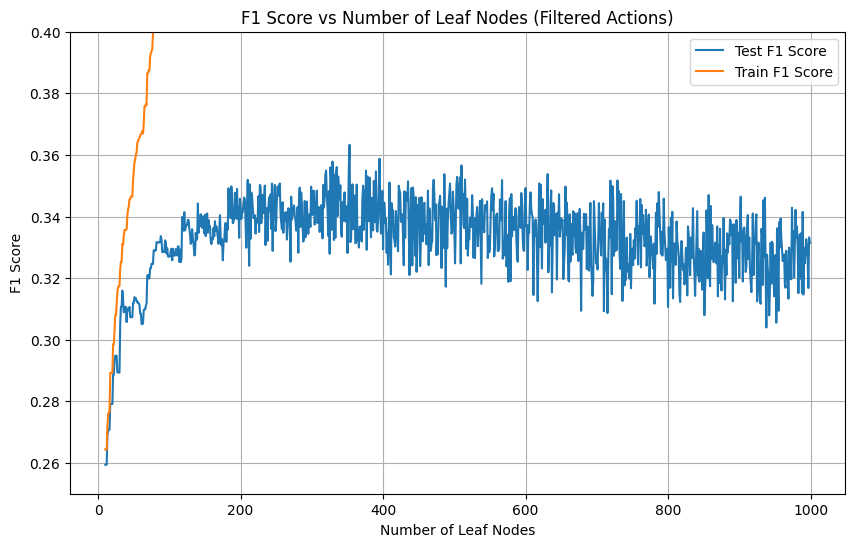

In [67]:
# Extract F1 scores for test and train
f1_scores_test = [score[0] for score in f1_scores]
f1_scores_train = [score[1] for score in f1_scores]

# Plot the F1 scores
plt.figure(figsize=(10, 6))
plt.plot(range(10, 1000, 1), f1_scores_test, label='Test F1 Score')
plt.plot(range(10, 1000, 1), f1_scores_train, label='Train F1 Score')

# Add labels, title, and legend
plt.xlabel('Number of Leaf Nodes')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Leaf Nodes (Filtered Actions)')
plt.legend()
plt.ylim(0.25, 0.4)
plt.grid()
plt.show()

In [68]:
x = GridSearchCV(
    estimator=model,
    param_grid={
        "max_leaf_nodes": range(10, 100, 10),
        "max_depth": [2, 3, 4, 5],
        "min_samples_leaf": range(1, 50, 5),
        "min_samples_split": range(1, 50, 5),
    },
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring="f1_macro"
)

x.fit(X_train, y_train)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits


/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1800 fits failed out of a total of 18000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1800 fits failed with the following error:
Traceback (most recent call last):
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py", line 436, in _validate_params
    vali

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, max_leaf_nodes=50),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5],
                         'max_leaf_nodes': range(10, 100, 10),
                         'min_samples_leaf': range(1, 50, 5),
                         'min_samples_split': range(1, 50, 5)},
             scoring='f1_macro', verbose=1)

In [69]:
params = pd.DataFrame(x.cv_results_)
params.sort_values(by=["rank_test_score", "param_max_leaf_nodes"], ascending=[True, True], inplace=True)
params = params[["params", "mean_test_score", "rank_test_score"]]
params

,params,mean_test_score,rank_test_score
3002,"{'max_depth': 5, 'max_leaf_nodes': 40, 'min_sa...",0.239874,1
2902,"{'max_depth': 5, 'max_leaf_nodes': 30, 'min_sa...",0.239239,2
2811,"{'max_depth': 5, 'max_leaf_nodes': 20, 'min_sa...",0.239106,3
2812,"{'max_depth': 5, 'max_leaf_nodes': 20, 'min_sa...",0.239106,3
2911,"{'max_depth': 5, 'max_leaf_nodes': 30, 'min_sa...",0.239106,3
...,...,...,...
3550,"{'max_depth': 5, 'max_leaf_nodes': 90, 'min_sa...",NaN,3241
3560,"{'max_depth': 5, 'max_leaf_nodes': 90, 'min_sa...",NaN,3241
3570,"{'max_depth': 5, 'max_leaf_nodes': 90, 'min_sa...",NaN,3241
3580,"{'max_depth': 5, 'max_leaf_nodes': 90, 'min_sa...",NaN,3241


In [70]:
# train on whole dataset (train)
best_params = params.iloc[0]["params"]
best_model = tree.DecisionTreeClassifier(**best_params)
best_model = best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

y_pred_train = best_model.predict(X_train)
print("Report Test")
print(classification_report(y_test, y_pred))
print("Report Train")
print(classification_report(y_train, y_pred_train))

Report Test
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        38
           3       0.64      0.15      0.24       139
           5       0.29      0.08      0.12        53
           7       0.00      0.00      0.00        12
           9       0.80      0.99      0.88       811

    accuracy                           0.78      1053
   macro avg       0.34      0.24      0.25      1053
weighted avg       0.71      0.78      0.72      1053

Report Train
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       127
           3       0.86      0.15      0.26       504
           5       0.39      0.11      0.18       238
           7       0.00      0.00      0.00        36
           9       0.81      0.99      0.89      3307

    accuracy                           0.80      4212
   macro avg       0.41      0.25      0.27      4212
weighted avg       0.76      0.80      0.74      421

/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [86]:
features_names, len(features_names)

(['bg',
  'enemy',
  'enemy_bullet',
  'enemy2',
  'enemy_fire',
  'player',
  'explosion',
  'player_bullet',
  'enemy_bullet'],
 9)

In [79]:
X.shape

(5265, 640)

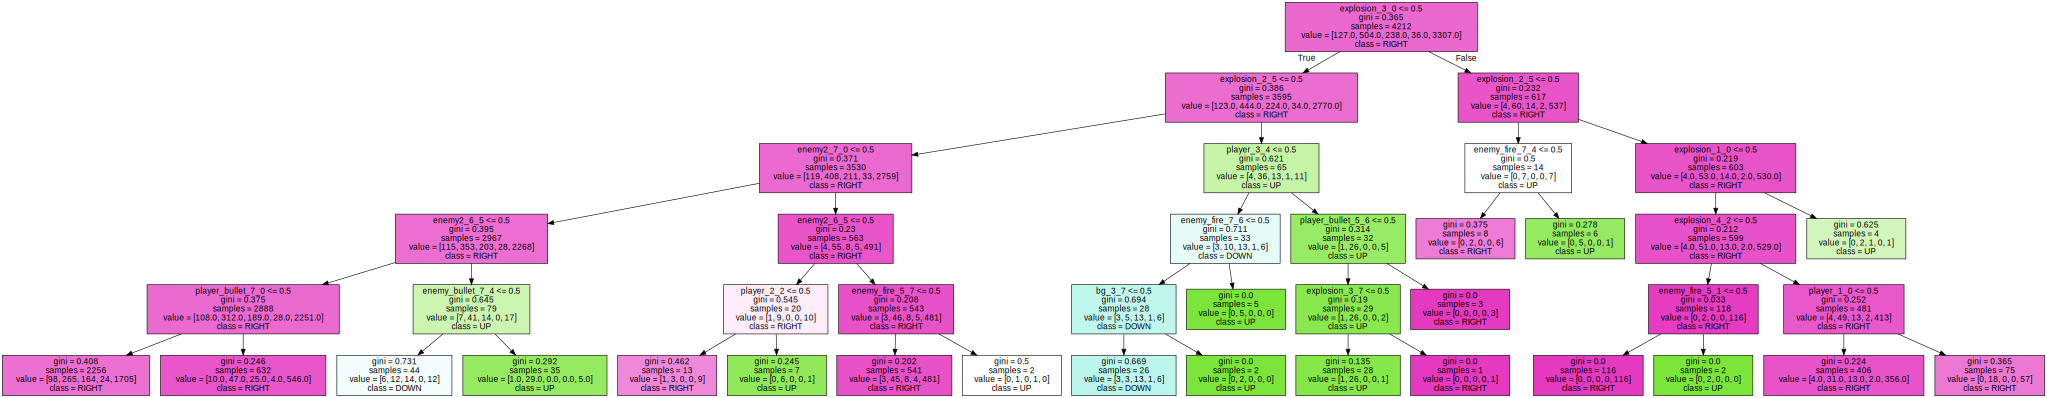

In [94]:
# visualize tree
import matplotlib.pyplot as plt

import graphviz


def get100(name):
    return [
        f"{name}_{i}_{j}" for i in range(8) for j in range(8)
    ]

features_names_all = [get100(features_names[i]) for i in range(len(features_names))]
features_names_all = np.array(features_names_all).flatten()
target_names = ["NOOP", "UP", "DOWN", "LEFT", "RIGHT", "FIRE"]
# DOT data
dot_data = tree.export_graphviz(best_model, out_file=None,
                                class_names=target_names,
                                feature_names=features_names_all,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, filename=None, format="png")
graph

In [95]:
# feature importance
importances = best_model.feature_importances_
print(len(importances))
indices = np.where(np.array(best_model.feature_importances_) > 0)[0]
importances = importances[indices]
features_names_important = features_names_all[indices]
print(features_names_important)

640
['bg_3_7' 'enemy_bullet_7_4' 'enemy2_6_5' 'enemy2_7_0' 'enemy_fire_5_1'
 'enemy_fire_5_7' 'enemy_fire_7_6' 'player_1_0' 'player_2_2' 'player_3_4'
 'explosion_1_0' 'explosion_2_5' 'explosion_3_0' 'explosion_3_7'
 'explosion_4_2' 'enemy_fire_7_4' 'player_bullet_5_6' 'player_bullet_7_0']


Text(0.5, 1.0, 'Feature Importance')

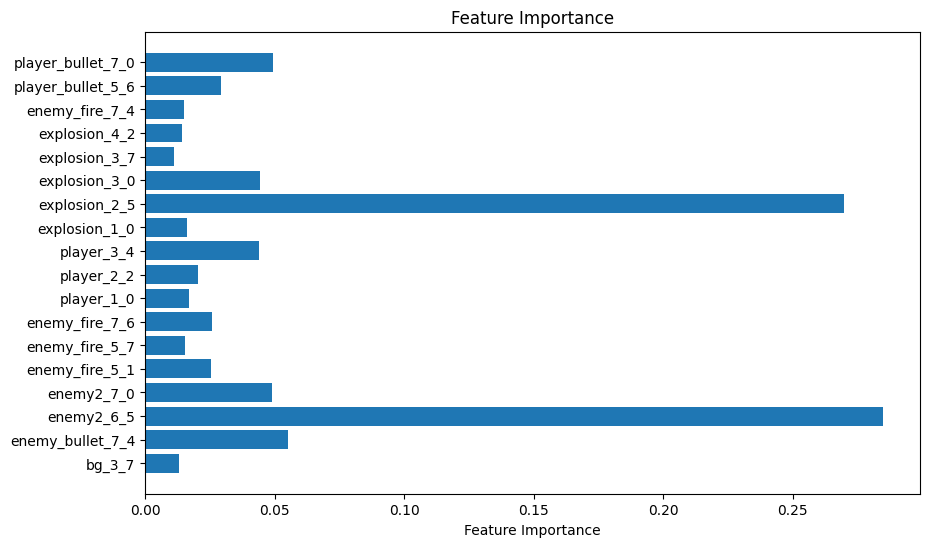

In [98]:
# plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), features_names_important)
plt.xlabel('Feature Importance')
plt.title('Feature Importance')




# train model only on features that are important for us

In [99]:
segmented.shape

(10000, 8, 8, 10)

In [100]:
features_names

['bg',
 'enemy',
 'enemy_bullet',
 'enemy2',
 'enemy_fire',
 'player',
 'explosion',
 'enemy_fire',
 'player_bullet',
 'enemy_bullet']

In [ ]:
# keep features in segmented
idxs = [
    1,2,3,4,5,8,9
]
segmented_reduced = segmented[:,:,:,idxs]
print(segmented_reduced.shape)

(10000, 8, 8, 7)
